## INITIALISING AMT AND RISK FREE PORTFOLIO

\[
\begin{aligned}
    & \underset{x}{\text{Maximize}} && \mu^T x - r_f x^T Q x \\
    & \text{subject to} && \sum_{j} x_j = 1, \\
    & && x \in C
\end{aligned}
\]

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

In [13]:
from fredapi import Fred

fred = Fred(api_key= '2d60db8717ba3d033f961ac04cf4855e')
ten_year_treasury_rate = fred.get_series('GS10')

#Set the risk free rate

risk_free_rate = ten_year_treasury_rate.iloc[-1] / 100
print(risk_free_rate)

0.042800000000000005


In [36]:
from curl_cffi import requests

session = requests.Session(impersonate="chrome")
ticker = yf.Ticker('AMT', session=session)
risk_free = yf.Ticker('^GSPC', session=session)

# Set time horizon using the `period` or `start`/`end` arguments
amt_data = ticker.history(period="1y")  # Last 1 year
sp500_data = risk_free.history(start="2023-01-01", end="2024-01-01")  # Custom range
return_df= amt_data[['Close']].reset_index()
return_df.columns = ['Date', 'Close']
riskfree_df = sp500_data[['Close']].reset_index()
riskfree_df.columns = ['Date', 'Close']

In [37]:
return_df['Date'] = pd.to_datetime(return_df['Date'])
return_df['Date'] = return_df['Date'].dt.strftime('%Y-%m-%d')
return_df.head()
riskfree_df['Date'] = pd.to_datetime(riskfree_df['Date'])
riskfree_df['Date'] = riskfree_df['Date'].dt.strftime('%Y-%m-%d')

In [33]:
muh = return_df['Close'].mean()
sigma = return_df['Close'].std()
returns = return_df['Close'].pct_change().dropna()

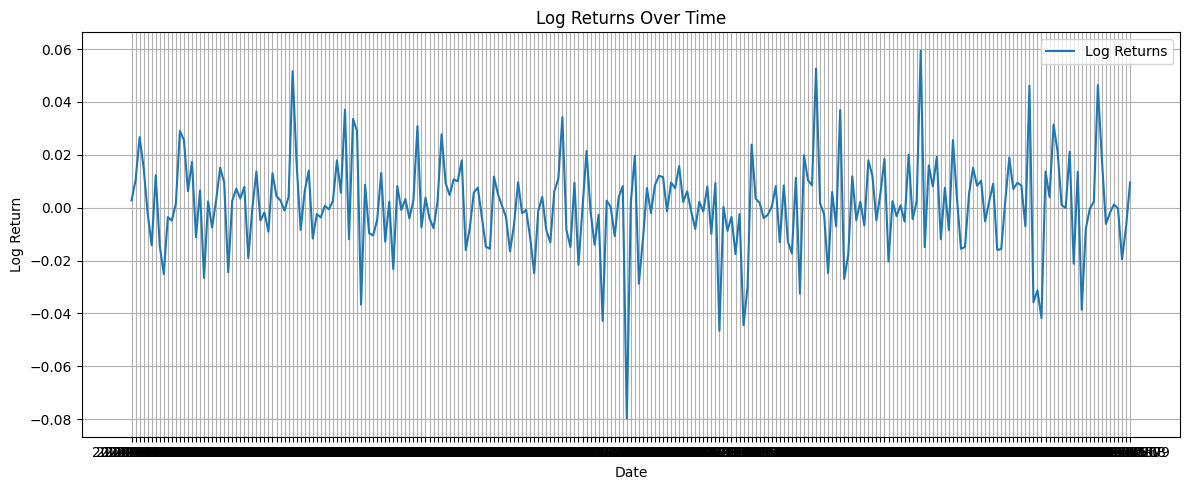

In [40]:
return_df['Log_Return'] = np.log(return_df['Close'] / return_df['Close'].shift(1))
return_df = return_df.dropna(subset=['Log_Return'])


plt.figure(figsize=(12, 5))
plt.plot(return_df['Date'], return_df['Log_Return'], label='Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Log Returns Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


using capm for SML plot

In [ ]:
from sklearn.linear_model import LinearRegression

return_df['Excess_return'] = return_df['Log_Return'].iloc[0] - risk_free_rate
sp500_data['Log_Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data['Excess_Market'] = sp500_data['Log_Return'] - risk_free_rate

# Align dates
merged = return_df.merge(sp500_data[['Date', 'Excess_Market']], on='Date', how='inner')

# Drop NaNs
merged = merged.dropna(subset=['Excess_Asset', 'Excess_Market'])

# Regression
X = merged[['Excess_Market']]
y = merged['Excess_Asset']
model = LinearRegression().fit(X, y)

beta = model.coef_[0]
alpha = model.intercept_
r_squared = model.score(X, y)